# Leave-One-Subject SVM

### Importing the Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import csv
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from collections import Counter

### Lists of Labels to be used for the Confusion Matrices

In [2]:
labels1 = ['Biking', 'Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
labels2 = ['Biking', 'Downstairs', 'Jogging', 'Standing_Sitting', 'Upstairs', 'Walking']

### Function to plot the Confusion Matrix

In [3]:
import itertools

plt.rcParams["font.family"] = 'DejaVu Sans'

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    ax = plt.gca()
    ax.set_ylim(-.5, float(len(classes))-0.5)
        
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Generic function to run any model specified

In [4]:
from datetime import datetime

def perform_model(model, X_train, y_train, X_test, y_test, class_labels, num, cm_normalize=True, \
                 print_cm=True, cm_cmap=plt.cm.Reds): #optional inputs, C_param, gamma_param, num
    
    
    # to store results at various phases
    results = dict()
    
    # time at which model starts training 
    train_start_time = datetime.now()
    print('training the model for participant no.' +str(num)+ '..')
    model.fit(X_train, y_train)
    
    print('Done \n \n')
    train_end_time = datetime.now()
    results['training_time'] =  train_end_time - train_start_time
    print('training_time(HH:MM:SS.ms) - {}\n\n'.format(results['training_time']))
    
    # predict test data
    print('Predicting test data')
    test_start_time = datetime.now()
    y_pred = model.predict(X_test)
    test_end_time = datetime.now()
    print('Done \n \n')
    results['testing_time'] = test_end_time - test_start_time
    print('testing time(HH:MM:SS:ms) - {}\n\n'.format(results['testing_time']))
    results['predicted'] = y_pred
   

    # calculate overall accuracty of the model
    accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
    # store accuracy in results
    results['accuracy'] = accuracy
    print('---------------------')
    print('|      Accuracy      |')
    print('---------------------')
    print('\n    {}\n\n'.format(accuracy))
    
    
    # confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    results['confusion_matrix'] = cm
    if print_cm:
        print('--------------------')
        print('| Confusion Matrix |')
        print('--------------------')
        print('\n {}'.format(cm))
        
    # plot confusin matrix
    plt.figure(figsize=(8,8))
    plt.grid(visible = False)
    plot_confusion_matrix(cm, classes=class_labels, normalize=True, title='Normalized confusion matrix', cmap = cm_cmap)
    ax = plt.gca()
    ax.set_ylim(-.5,float(len(class_labels))-0.5)
    plt.show()
    
    # get classification report
    print('-------------------------')
    print('| Classifiction Report |')
    print('-------------------------')
    class_report = classification_report(y_test, y_pred)
    # store report in results
    results['classification_report'] = class_report
    print(class_report)
    
    # add the trained  model to the results
    results['model'] = model
    
    return results

### Method to print the Grid Search results

In [5]:
def print_grid_search_attributes(model, num): #or 'results' as input
    print('grid search for participant no.' +str(num)+ '..')
    print('Done \n \n')
    
    # Estimator that gave highest score among all the estimators formed in GridSearch
    print('--------------------------')
    print('|      Best Estimator     |')
    print('--------------------------')
    
    
    print('\n\t{}\n'.format(model.best_estimator_))
    best_estimator = model.best_estimator_


    # parameters that gave best results while performing grid search
    print('--------------------------')
    print('|     Best parameters     |')
    print('--------------------------')
                                                               
    
    print('\tParameters of best estimator : \n\n\t{}\n'.format(model.best_params_))
    best_params = model.best_params_


    #  number of cross validation splits
    print('---------------------------------')
    print('|   No of CrossValidation sets   |')
    print('--------------------------------')
    print('\n\tTotal number of cross validation sets: {}\n'.format(model.n_splits_))


    # Average cross validated score of the best estimator, from the Grid Search 
    print('--------------------------')
    print('|        Best Score       |')
    print('--------------------------')
    
    
    print('\n\tAverage Cross Validate scores of best estimator : \n\n\t{}\n'.format(model.best_score_))
    
    return best_estimator, best_params

### LOSO SVM function - along with a grid search for the optimal model

In [6]:
#Function that finds the most common element in a list
def most_common(List):
    count = Counter(List)
    return count.most_common(1)[0][0]

In [7]:
#os.makedirs('LOSO_SVM/confusion_matrices', exist_ok=True)

def LOSO_SVM():
    
    #lists to store the confusion matrix and accuracy for each participant
    cm_list = []
    acc_list = []
    
    #list to store the predicted values and the test values
    yTest = []
    yPred = []
    
    #list to store the optimal parameters and the best model
    best_parameters = []
    best_estimators = []
    
    #the first 'for' loop validates the optimal parameters using the LOSO cross validation
    for i in range(0, 10):
        X_train = pd.read_csv('train_test_dataset/X_train_fold_' +str(i+1)+ '.csv').values
        X_test = pd.read_csv('train_test_dataset/X_test_fold_' +str(i+1)+ '.csv').values
        y_train = pd.read_csv('train_test_dataset/y_train_fold_' +str(i+1)+ '.csv').values.ravel()
        y_test = pd.read_csv('train_test_dataset/y_test_fold_' +str(i+1)+ '.csv').values.ravel()
        
        parameters = {'C': [100], 'gamma': [0.0078125]}
        
        scaler = StandardScaler()
        X_train_norm = scaler.fit_transform(X_train)
        X_test_norm = scaler.transform(X_test)
        
        rbf_svm = SVC(kernel = 'rbf')
        rbf_svm_grid = GridSearchCV(rbf_svm, scoring='accuracy', param_grid=parameters, cv=10, n_jobs=-1)
        rbf_svm_grid.fit(X_train_norm, y_train)
        ypred = rbf_svm_grid.predict(X_test)

        optimal_estim, optimal_param = print_grid_search_attributes(rbf_svm_grid, i+1)
        
        best_parameters.append(optimal_param)
        best_estimators.append(optimal_estim)
    
    #in the second 'for' loop we train the model with the optimal parameters
    for j in range(10):
        X_train = pd.read_csv('train_test_dataset/X_train_fold_' +str(j+1)+ '.csv').values
        X_test = pd.read_csv('train_test_dataset/X_test_fold_' +str(j+1)+ '.csv').values
        y_train = pd.read_csv('train_test_dataset/y_train_fold_' +str(j+1)+ '.csv').values.ravel()
        y_test = pd.read_csv('train_test_dataset/y_test_fold_' +str(j+1)+ '.csv').values.ravel()
        
        scaler = MinMaxScaler()
        X_train_norm = scaler.fit_transform(X_train)
        X_test_norm = scaler.transform(X_test)
        
        best_rbf_svm = most_common(best_estimators)
        best_rbf_svm_results = perform_model(best_rbf_svm, X_train_norm, y_train, X_test_norm, y_test,\
                                class_labels=labels1, num=j+1)
        
        y_pred = best_rbf_svm_results['predicted']
        
        yTest.extend(y_test)
        yPred.extend(y_pred)
        
        cm = best_rbf_svm_results['confusion_matrix']
        #np.savetxt('LOSO_SVM/confusion_matrices/cm_' +str(j+1)+ '.csv', cm, delimiter=',')
        acc = best_rbf_svm_results['accuracy']
        
        cm_list.append(cm)
        acc_list.append(acc)
        
    return cm_list, yTest, yPred, best_rbf_svm 

In [ ]:
cm, yTest, yPred, best_estimator = LOSO_SVM()

### Method to save the y_test and y_pred results

Run the following code snippet if you wish to run the whole file

In [9]:
#os.makedirs('LOSO_SVM/test_y_pred', exist_ok=True)

#with open('LOSO_SVM/test_y_pred/yTest.csv', 'w', newline='') as file:
#    writer = csv.writer(file)
    
#    for item in yTest:
#        writer.writerow([item])
        
#with open('LOSO_SVM/test_y_pred/yPred.csv', 'w', newline='') as file:
#    writer = csv.writer(file)
    
#    for item in yPred:
#        writer.writerow([item])

### Method to load the y_test and y_pred results

Run the following code snippet if you just wish to load the files from the folder

In [10]:
#yTest=[]
#with open('LOSO_SVM/test_y_pred/yTest.csv', 'r') as file:
#    reader = csv.reader(file)
#    for row in reader:
#        yTest.append(row[0])
#
#yPred=[]
#with open('LOSO_SVM/test_y_pred/yPred.csv', 'r') as file:
#    reader = csv.reader(file)
#    for row in reader:
#        yPred.append(row[0])

### Method to print the Confusion Matrix of all participants

If the user wishes to run the whole file, he should unpin the '#' comment line and pin as comments the '#<---#' lines.

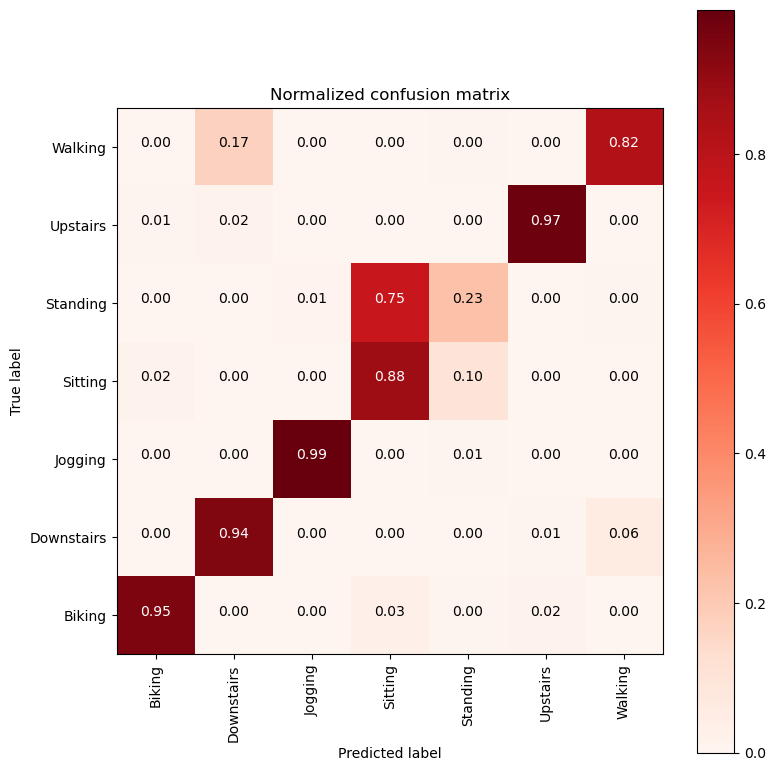

In [11]:
complete_conf_matrix = cm[0] + cm[1] + cm[2] + cm[3] + cm[4] + cm[5] + cm[6] + cm[7] + cm[8] + cm[9]

#cm_list = [] #<---#
#for i in range(10): #<---#
#    cm = np.loadtxt('LOSO_SVM/confusion_matrices/cm_' +str(i+1)+ '.csv', delimiter=',').astype(np.int64) #<---#
#    cm_list.append(cm) #<---#
    
#complete_conf_matrix = np.sum(cm_list, axis=0) #<---#

plt.rcParams['font.family'] = 'DejaVu Sans'

plt.figure(figsize=(8,8))
plt.grid(visible = False)
plot_confusion_matrix(complete_conf_matrix, classes=labels1, normalize=True, title='Normalized confusion matrix', cmap = plt.cm.Reds)
ax = plt.gca()
ax.set_ylim(-.5,6.5)
plt.show()

### Code snippet to print the middle accuracy

In [12]:
print('-------------------')
print('| Middle Accuracy |')
print('-------------------')
middle_acc = complete_conf_matrix.diagonal() / complete_conf_matrix.sum(axis = 1)
print(middle_acc)

-------------------
| Middle Accuracy |
-------------------
[0.94888889 0.93862434 0.99277778 0.88       0.22833333 0.97444444
 0.82222222]


### Code snippet to print the Classification Report for all participans

In [13]:
print('----------------------------------------------')
print('| Classification Report for all Participants |')
print('----------------------------------------------')
cr = classification_report(yTest, yPred, target_names=labels1)
print(cr)

----------------------------------------------
| Classification Report for all Participants |
----------------------------------------------
              precision    recall  f1-score   support

      Biking       0.97      0.95      0.96      1800
  Downstairs       0.84      0.94      0.89      1890
     Jogging       0.99      0.99      0.99      1800
     Sitting       0.53      0.88      0.66      1800
    Standing       0.67      0.23      0.34      1800
    Upstairs       0.98      0.97      0.97      1800
     Walking       0.93      0.82      0.87      1710

    accuracy                           0.83     12600
   macro avg       0.84      0.83      0.81     12600
weighted avg       0.84      0.83      0.81     12600



### Code snippet to print the accuracy for all participants

In [14]:
print('---------------------------------')
print('| Accuracy for all Participants |')
print('---------------------------------')
acc_score = accuracy_score(yTest, yPred)
print('\n\t{}\n'.format(acc_score))

---------------------------------
| Accuracy for all Participants |
---------------------------------

	0.8273015873015873



### LOSO SVM Function of the regrouped dataset

The parameters that are used to train and test the classifier are the optimal parameters that are found in the grid search above. After noticing that the algorithm confuses the 'walking' and 'standing' classes we joined those classes and performed LOSO Cross Validation to the regrouped dataset.

In [15]:
#os.makedirs('LOSO_SVM/regrouped_confusion_matrices', exist_ok=True)

def LOSO_SVM_REGROUPED():
    
    cm_list = []
    acc_list = []
    
    yTest = []
    yPred = []
    
    for i in range(0, 10):
        X_train = pd.read_csv('train_test_dataset/X_train_fold_' +str(i+1)+ '.csv').values
        X_test = pd.read_csv('train_test_dataset/X_test_fold_' +str(i+1)+ '.csv').values
        y_train = pd.read_csv('regrouped_dataset/y_train_' +str(i+1)+ '_regrouped.csv').values.ravel()
        y_test = pd.read_csv('regrouped_dataset/y_test_' +str(i+1)+ '_regrouped.csv').values.ravel()
        
        scaler = MinMaxScaler()
        X_train_norm = scaler.fit_transform(X_train)
        X_test_norm = scaler.transform(X_test)
        
        rbf_svm = best_estimator
        rbf_svm_results = perform_model(rbf_svm, X_train_norm, y_train, X_test_norm, y_test,\
                                             class_labels=labels2, num=i+1)
        
        y_pred = rbf_svm_results['predicted']
        
        yTest.extend(y_test)
        yPred.extend(y_pred)
        
        cm = rbf_svm_results['confusion_matrix']
        #np.savetxt('LOSO_SVM/regrouped_confusion_matrices/cm_' +str(i+1)+ '_regrouped.csv', cm, delimiter=',')
        acc = rbf_svm_results['accuracy']
        
        cm_list.append(cm)
        acc_list.append(acc)
        
    return cm_list, yTest, yPred

training the model for participant no.1..
Done 
 

training_time(HH:MM:SS.ms) - 0:00:00.255085


Predicting test data
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.069443


---------------------
|      Accuracy      |
---------------------

    0.9563492063492064


--------------------
| Confusion Matrix |
--------------------

 [[160   1   0  19   0   0]
 [  0 189   0   0   0   0]
 [  0   0 180   0   0   0]
 [  0   0   5 352   0   3]
 [  0  27   0   0 153   0]
 [  0   0   0   0   0 171]]


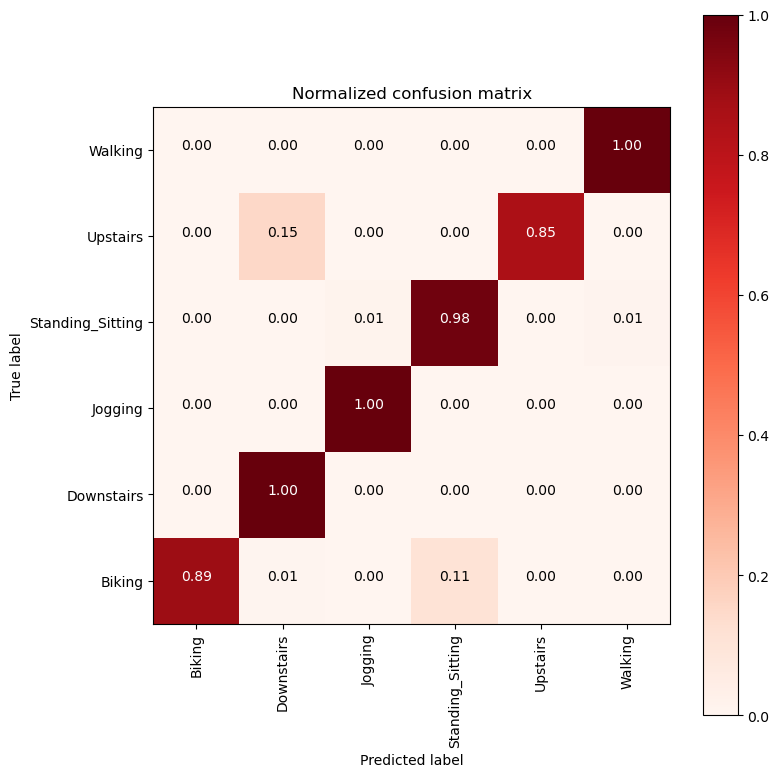

-------------------------
| Classifiction Report |
-------------------------
                  precision    recall  f1-score   support

          biking       1.00      0.89      0.94       180
      downstairs       0.87      1.00      0.93       189
         jogging       0.97      1.00      0.99       180
standing_sitting       0.95      0.98      0.96       360
        upstairs       1.00      0.85      0.92       180
         walking       0.98      1.00      0.99       171

        accuracy                           0.96      1260
       macro avg       0.96      0.95      0.96      1260
    weighted avg       0.96      0.96      0.96      1260

training the model for participant no.2..
Done 
 

training_time(HH:MM:SS.ms) - 0:00:00.313067


Predicting test data
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.076833


---------------------
|      Accuracy      |
---------------------

    0.9103174603174603


--------------------
| Confusion Matrix |
--------------------

 [[178   0 

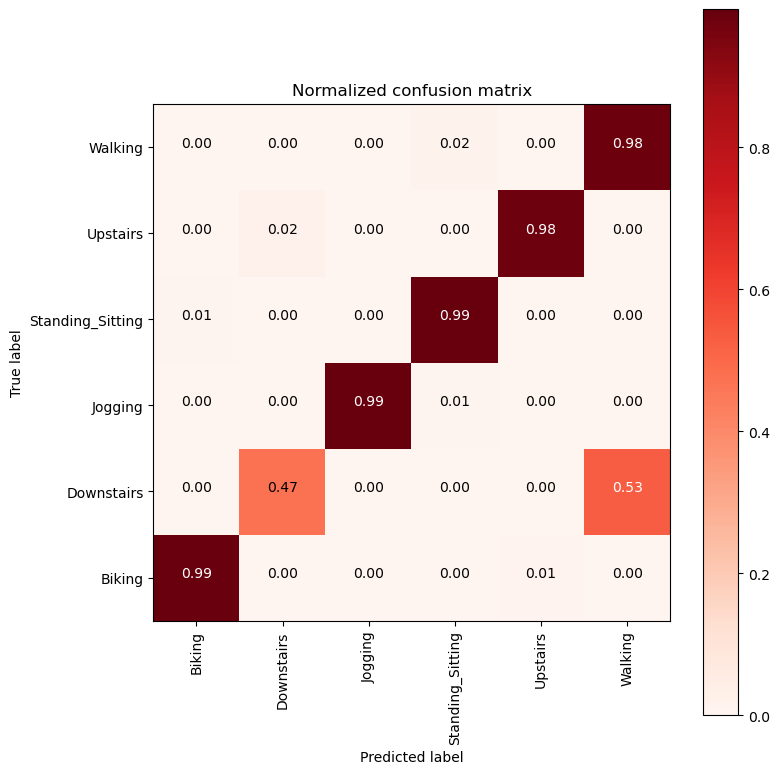

-------------------------
| Classifiction Report |
-------------------------
                  precision    recall  f1-score   support

          biking       0.99      0.99      0.99       180
      downstairs       0.96      0.47      0.63       189
         jogging       0.99      0.99      0.99       180
standing_sitting       0.99      0.99      0.99       360
        upstairs       0.99      0.98      0.98       180
         walking       0.63      0.98      0.77       171

        accuracy                           0.91      1260
       macro avg       0.92      0.90      0.89      1260
    weighted avg       0.94      0.91      0.91      1260

training the model for participant no.3..
Done 
 

training_time(HH:MM:SS.ms) - 0:00:00.270157


Predicting test data
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.070348


---------------------
|      Accuracy      |
---------------------

    0.9706349206349206


--------------------
| Confusion Matrix |
--------------------

 [[167   0 

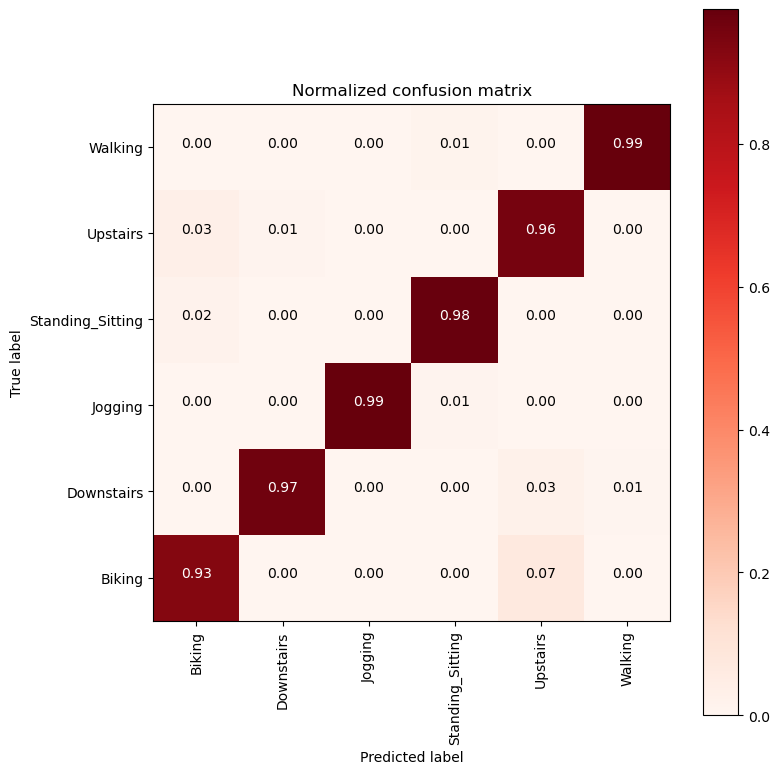

-------------------------
| Classifiction Report |
-------------------------
                  precision    recall  f1-score   support

          biking       0.93      0.93      0.93       180
      downstairs       0.99      0.97      0.98       189
         jogging       1.00      0.99      0.99       180
standing_sitting       0.99      0.98      0.99       360
        upstairs       0.91      0.96      0.93       180
         walking       0.99      0.99      0.99       171

        accuracy                           0.97      1260
       macro avg       0.97      0.97      0.97      1260
    weighted avg       0.97      0.97      0.97      1260

training the model for participant no.4..
Done 
 

training_time(HH:MM:SS.ms) - 0:00:00.263833


Predicting test data
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.078808


---------------------
|      Accuracy      |
---------------------

    0.9166666666666666


--------------------
| Confusion Matrix |
--------------------

 [[176   0 

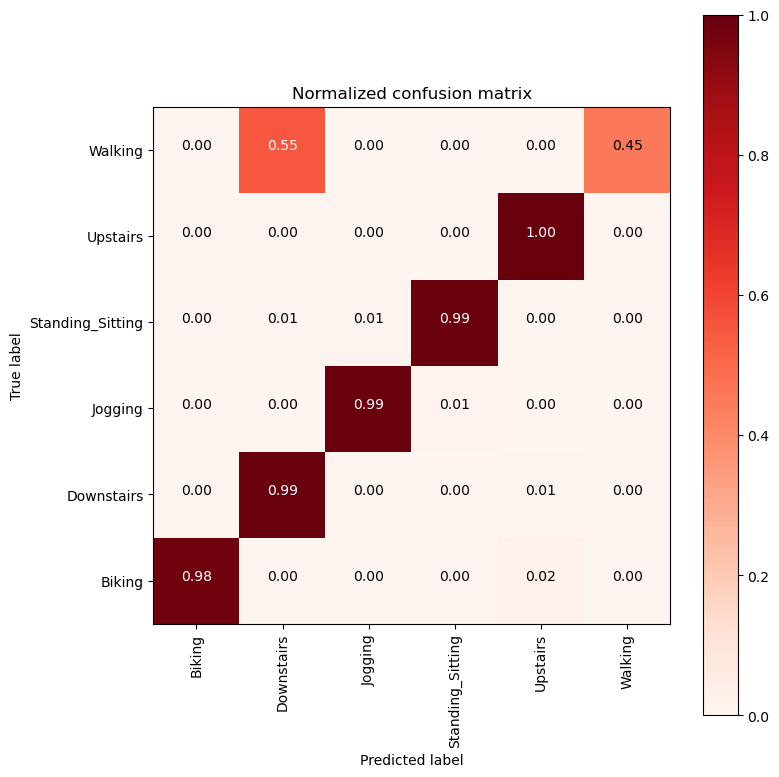

-------------------------
| Classifiction Report |
-------------------------
                  precision    recall  f1-score   support

          biking       1.00      0.98      0.99       180
      downstairs       0.66      0.99      0.79       189
         jogging       0.99      0.99      0.99       180
standing_sitting       0.99      0.99      0.99       360
        upstairs       0.97      1.00      0.99       180
         walking       1.00      0.45      0.62       171

        accuracy                           0.92      1260
       macro avg       0.94      0.90      0.90      1260
    weighted avg       0.94      0.92      0.91      1260

training the model for participant no.5..
Done 
 

training_time(HH:MM:SS.ms) - 0:00:00.268219


Predicting test data
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.073826


---------------------
|      Accuracy      |
---------------------

    0.9904761904761905


--------------------
| Confusion Matrix |
--------------------

 [[171   0 

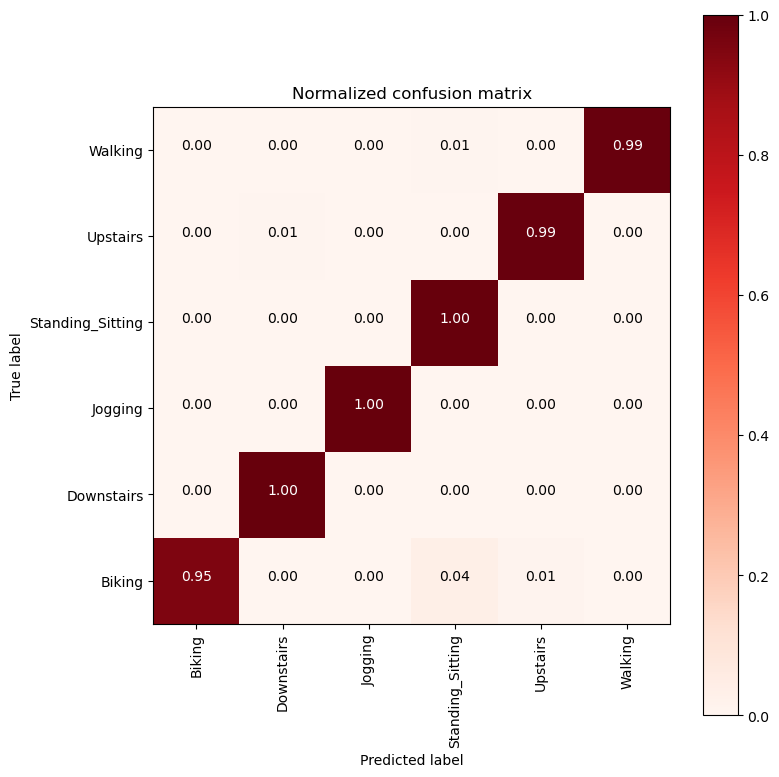

-------------------------
| Classifiction Report |
-------------------------
                  precision    recall  f1-score   support

          biking       1.00      0.95      0.97       180
      downstairs       0.99      1.00      1.00       189
         jogging       0.99      1.00      1.00       180
standing_sitting       0.98      1.00      0.99       360
        upstairs       0.99      0.99      0.99       180
         walking       1.00      0.99      1.00       171

        accuracy                           0.99      1260
       macro avg       0.99      0.99      0.99      1260
    weighted avg       0.99      0.99      0.99      1260

training the model for participant no.6..
Done 
 

training_time(HH:MM:SS.ms) - 0:00:00.288838


Predicting test data
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.084840


---------------------
|      Accuracy      |
---------------------

    0.957936507936508


--------------------
| Confusion Matrix |
--------------------

 [[175   0  

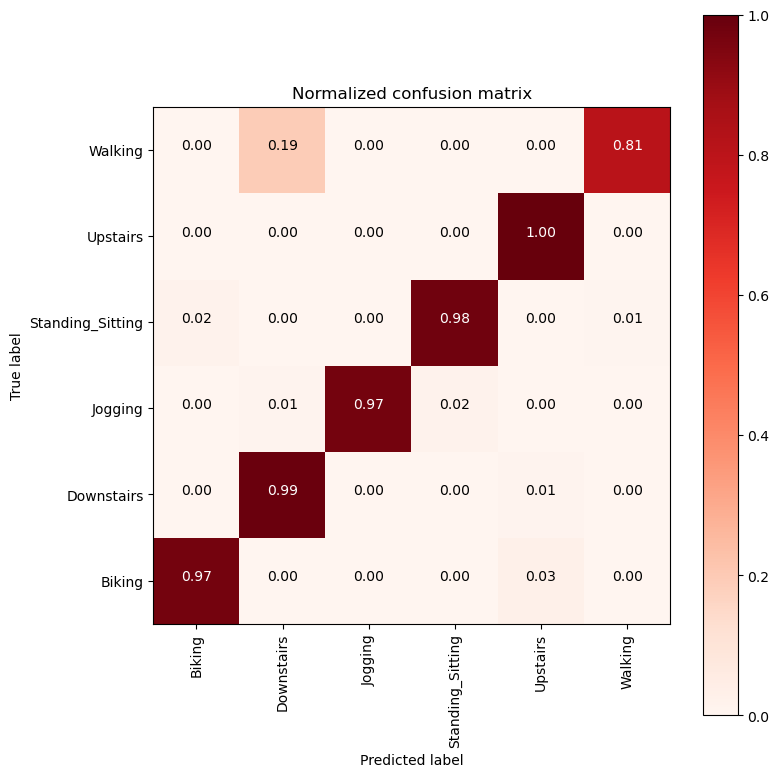

-------------------------
| Classifiction Report |
-------------------------
                  precision    recall  f1-score   support

          biking       0.97      0.97      0.97       180
      downstairs       0.84      0.99      0.91       189
         jogging       1.00      0.97      0.99       180
standing_sitting       0.99      0.98      0.98       360
        upstairs       0.96      1.00      0.98       180
         walking       0.99      0.81      0.89       171

        accuracy                           0.96      1260
       macro avg       0.96      0.95      0.95      1260
    weighted avg       0.96      0.96      0.96      1260

training the model for participant no.7..
Done 
 

training_time(HH:MM:SS.ms) - 0:00:00.268314


Predicting test data
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.071678


---------------------
|      Accuracy      |
---------------------

    0.9793650793650793


--------------------
| Confusion Matrix |
--------------------

 [[172   1 

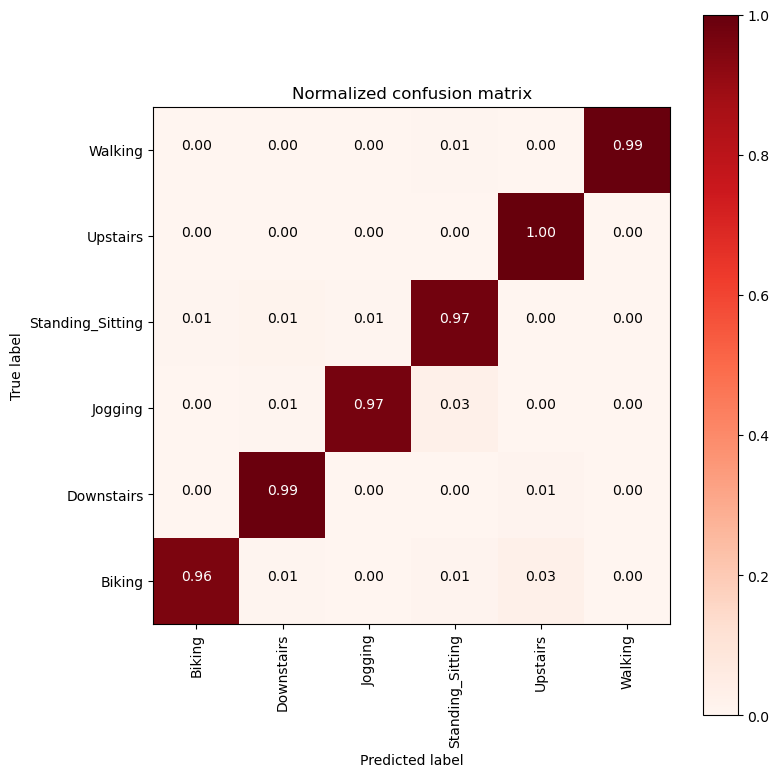

-------------------------
| Classifiction Report |
-------------------------
                  precision    recall  f1-score   support

          biking       0.99      0.96      0.97       180
      downstairs       0.96      0.99      0.98       189
         jogging       0.99      0.97      0.98       180
standing_sitting       0.98      0.97      0.98       360
        upstairs       0.96      1.00      0.98       180
         walking       1.00      0.99      1.00       171

        accuracy                           0.98      1260
       macro avg       0.98      0.98      0.98      1260
    weighted avg       0.98      0.98      0.98      1260

training the model for participant no.8..
Done 
 

training_time(HH:MM:SS.ms) - 0:00:00.265242


Predicting test data
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.078452


---------------------
|      Accuracy      |
---------------------

    0.9857142857142858


--------------------
| Confusion Matrix |
--------------------

 [[180   0 

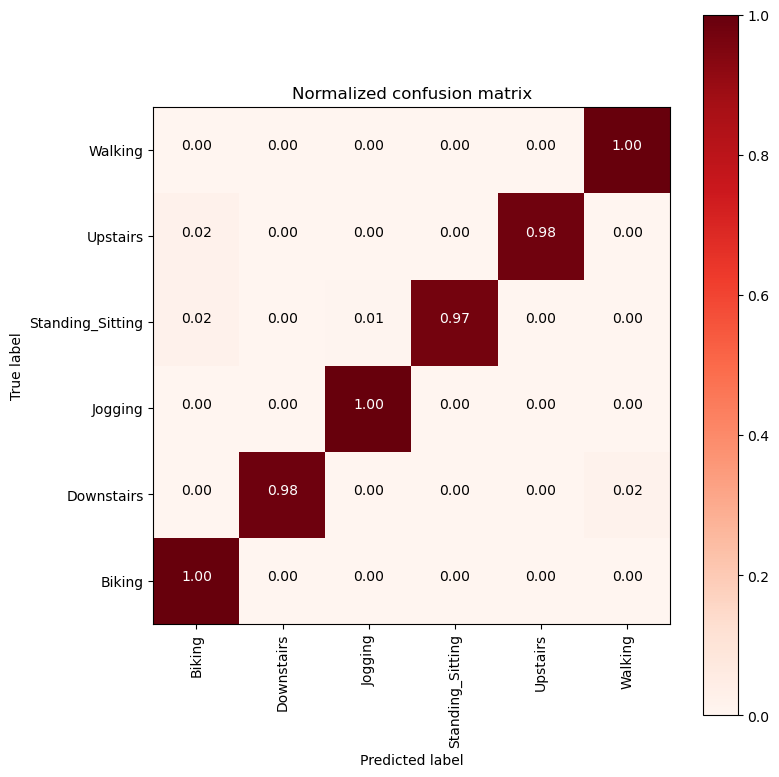

-------------------------
| Classifiction Report |
-------------------------
                  precision    recall  f1-score   support

          biking       0.94      1.00      0.97       180
      downstairs       1.00      0.98      0.99       189
         jogging       0.99      1.00      0.99       180
standing_sitting       1.00      0.97      0.98       360
        upstairs       1.00      0.98      0.99       180
         walking       0.98      1.00      0.99       171

        accuracy                           0.99      1260
       macro avg       0.98      0.99      0.99      1260
    weighted avg       0.99      0.99      0.99      1260

training the model for participant no.9..
Done 
 

training_time(HH:MM:SS.ms) - 0:00:00.248469


Predicting test data
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.068951


---------------------
|      Accuracy      |
---------------------

    0.9674603174603175


--------------------
| Confusion Matrix |
--------------------

 [[147   0 

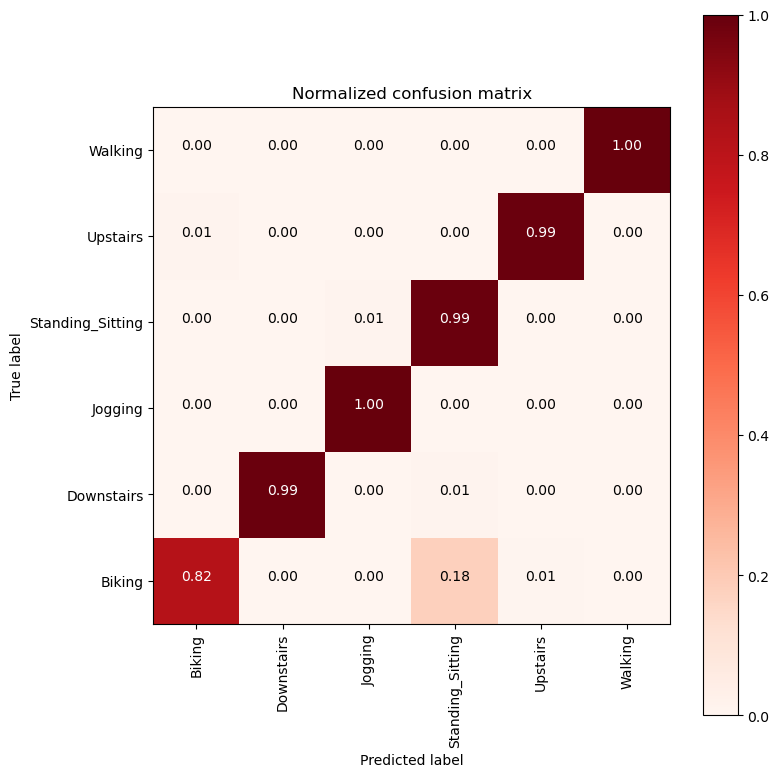

-------------------------
| Classifiction Report |
-------------------------
                  precision    recall  f1-score   support

          biking       0.99      0.82      0.89       180
      downstairs       1.00      0.99      0.99       189
         jogging       0.98      1.00      0.99       180
standing_sitting       0.91      0.99      0.95       360
        upstairs       0.99      0.99      0.99       180
         walking       1.00      1.00      1.00       171

        accuracy                           0.97      1260
       macro avg       0.98      0.96      0.97      1260
    weighted avg       0.97      0.97      0.97      1260

training the model for participant no.10..
Done 
 

training_time(HH:MM:SS.ms) - 0:00:00.236533


Predicting test data
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.072928


---------------------
|      Accuracy      |
---------------------

    0.8547619047619047


--------------------
| Confusion Matrix |
--------------------

 [[180   0

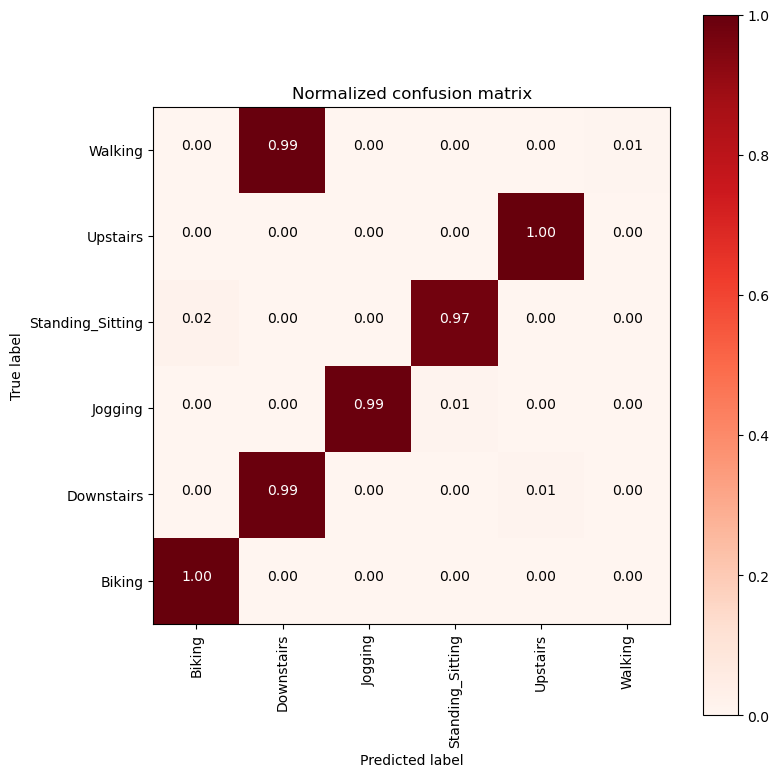

-------------------------
| Classifiction Report |
-------------------------
                  precision    recall  f1-score   support

          biking       0.96      1.00      0.98       180
      downstairs       0.52      0.99      0.68       189
         jogging       1.00      0.99      0.99       180
standing_sitting       0.99      0.97      0.98       360
        upstairs       0.99      1.00      0.99       180
         walking       0.50      0.01      0.01       171

        accuracy                           0.85      1260
       macro avg       0.83      0.83      0.77      1260
    weighted avg       0.85      0.85      0.81      1260



In [16]:
cm_list_regrouped, yTest_regrouped, yPred_regrouped = LOSO_SVM_REGROUPED()

### Method for saving the yTest_regrouped and yPred_regrouped

Run the following code snippet if you wish to run the whole file

In [17]:
#os.makedirs('LOSO_SVM/test_y_pred', exist_ok=True)

#with open('LOSO_SVM/test_y_pred/yTest_regrouped.csv', 'w', newline='') as file:
#    writer = csv.writer(file)
    
#    for item in yTest_regrouped:
#        writer.writerow([item])
        
#with open('LOSO_SVM/test_y_pred/yPred_regrouped.csv', 'w', newline='') as file:
#    writer = csv.writer(file)
    
#    for item in yPred_regrouped:
#        writer.writerow([item])

### Method for loading yTest_regrouped and yPred_regrouped

Run the following code snippet if you just wish to load the files from the folder

In [18]:
#yTest_regrouped = []
#with open('LOSO_SVM/test_y_pred/yTest_regrouped.csv', 'r') as file:
#    reader = csv.reader(file)
#    for row in reader:
#        yTest_regrouped.append(row[0])

#yPred_regrouped = []
#with open('LOSO_SVM/test_y_pred/yPred_regrouped.csv', 'r') as file:
#    reader = csv.reader(file)
#    for row in reader:
#        yPred_regrouped.append(row[0])

### Method for printing the regrouped Confusion Matrix for all participants

If the user wishes to run the whole file, he should unpin the '#' comment line and pin as comments the '#<---#' lines.

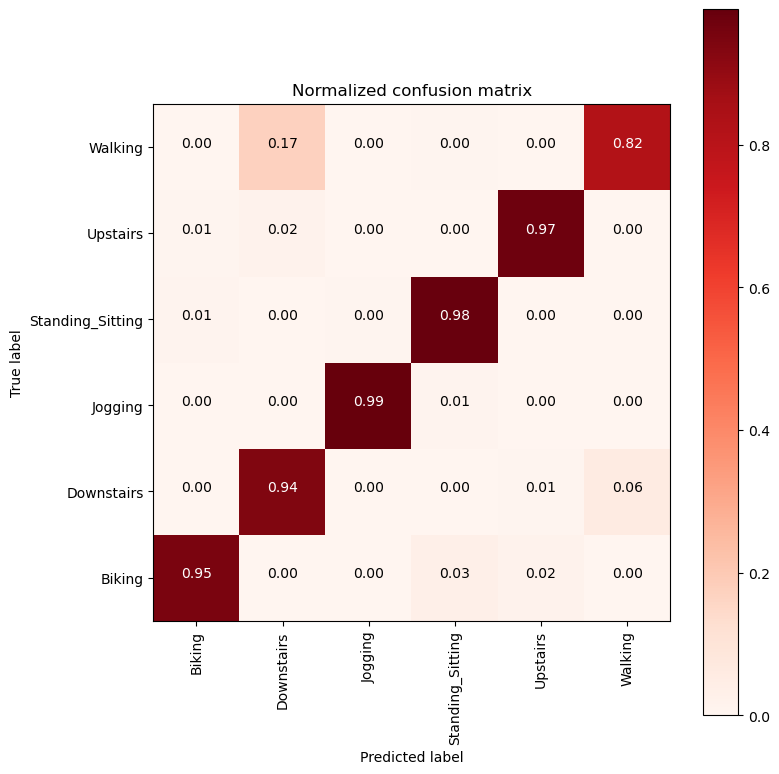

In [19]:
cm_regrouped = cm_list_regrouped[0] + cm_list_regrouped[1] + cm_list_regrouped[2] + cm_list_regrouped[3] + cm_list_regrouped[4] + cm_list_regrouped[5] + cm_list_regrouped[6] + cm_list_regrouped[7] + cm_list_regrouped[8] + cm_list_regrouped[9]

#cm_list_regrouped = [] #<---#
#for i in range(10): #<---#
#    matrix = np.loadtxt('LOSO_SVM/regrouped_confusion_matrices/cm_' +str(i+1)+ '_regrouped.csv', delimiter=',').astype(np.int64) #<---#
#    cm_list_regrouped.append(matrix) #<---#
    
#cm_regrouped = np.sum(cm_list_regrouped, axis=0) #<---#
    

plt.rcParams['font.family'] = 'DejaVu Sans'

plt.figure(figsize=(8,8))
plt.grid(visible = False)
plot_confusion_matrix(cm_regrouped, classes=labels2, normalize=True, title='Normalized confusion matrix', cmap = plt.cm.Reds)
ax = plt.gca()
ax.set_ylim(-.5,5.5)
plt.show()

### Code snippet to print the Classification Report of the regrouped dataset for all participants

In [20]:
print('----------------------------------------------')
print('| Classification Report for all Participants |')
print('----------------------------------------------')
cr_regrouped = classification_report(yTest_regrouped, yPred_regrouped, target_names=labels2)
print(cr_regrouped)

----------------------------------------------
| Classification Report for all Participants |
----------------------------------------------
                  precision    recall  f1-score   support

          Biking       0.98      0.95      0.96      1800
      Downstairs       0.84      0.94      0.88      1890
         Jogging       0.99      0.99      0.99      1800
Standing_Sitting       0.98      0.98      0.98      3600
        Upstairs       0.98      0.97      0.97      1800
         Walking       0.93      0.82      0.87      1710

        accuracy                           0.95     12600
       macro avg       0.95      0.94      0.94     12600
    weighted avg       0.95      0.95      0.95     12600



### Code snippet to print the accuracy of the regrouped dataset for all participants

In [21]:
print('---------------------------------')
print('| Accuracy for all Participants |')
print('---------------------------------')
acc_score = accuracy_score(yTest_regrouped, yPred_regrouped)
print('\n\t{}\n'.format(acc_score))

---------------------------------
| Accuracy for all Participants |
---------------------------------

	0.948968253968254



In [22]:
def optimal_estimator(n):
    train_x = pd.read_csv('10_Subject_Dataset/X_train.csv').values
    train_y = pd.read_csv('10_Subject_Dataset/y_train.csv').values
    
    participant_l = pd.read_csv('dataset/Left_Pocket_Dataset/Participant_' +str(n)+ '_left.csv')
    x_left = participant_l.iloc[:, :-1].values
    y_left = participant_l.iloc[:, -1].values
    
    participant_w = pd.read_csv('dataset/Wrist_Dataset/Participant_' +str(n)+ '_wrist.csv')
    x_wrist = participant_w.iloc[:, :-1].values
    y_wrist = participant_w.iloc[:, -1].values
    
    scaler = MinMaxScaler()
    train_x = scaler.fit_transform(train_x)
    x_left = scaler.transform(x_left)
    x_wrist = scaler.transform(x_wrist)
    
    model = best_estimator
    model.fit(train_x, train_y)
    
    prediction_left = model.predict(x_left)
    prediction_wrist = model.predict(x_wrist)
    
    return prediction_left, prediction_wrist, y_left, y_wrist

In [23]:
prediction_left, prediction_wrist, y_left, y_wrist = optimal_estimator(5)

/home/paschalis/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


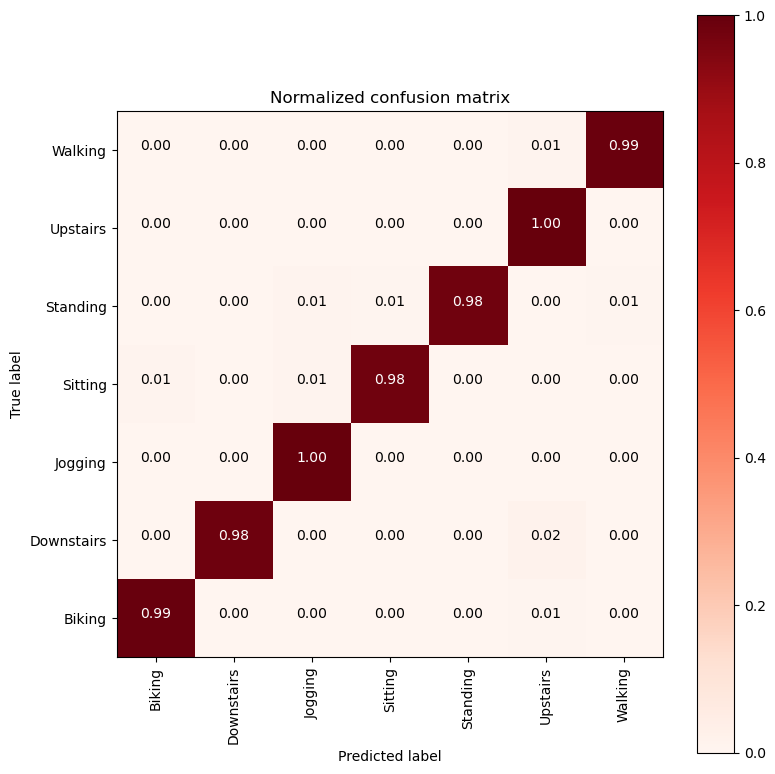

In [24]:
cm_left = confusion_matrix(y_left, prediction_left)

plt.rcParams['font.family'] = 'DejaVu Sans'

plt.figure(figsize=(8,8))
plt.grid(visible = False)
plot_confusion_matrix(cm_left, classes=labels1, normalize=True, title='Normalized confusion matrix', cmap = plt.cm.Reds)
ax = plt.gca()
ax.set_ylim(-.5,6.5)
plt.show()

In [25]:
print('----------------------------------------------')
print('| Classification Report for all Participants |')
print('----------------------------------------------')
cr_left = classification_report(y_left, prediction_left, target_names=labels1)
print(cr_left)

----------------------------------------------
| Classification Report for all Participants |
----------------------------------------------
              precision    recall  f1-score   support

      Biking       0.99      0.99      0.99       180
  Downstairs       1.00      0.98      0.99       189
     Jogging       0.98      1.00      0.99       180
     Sitting       0.99      0.98      0.99       180
    Standing       1.00      0.98      0.99       180
    Upstairs       0.97      1.00      0.98       180
     Walking       0.99      0.99      0.99       171

    accuracy                           0.99      1260
   macro avg       0.99      0.99      0.99      1260
weighted avg       0.99      0.99      0.99      1260



In [26]:
print('---------------------------------')
print('| Accuracy for all Participants |')
print('---------------------------------')
acc_score = accuracy_score(y_left, prediction_left)
print('\n\t{}\n'.format(acc_score))

---------------------------------
| Accuracy for all Participants |
---------------------------------

	0.9888888888888889



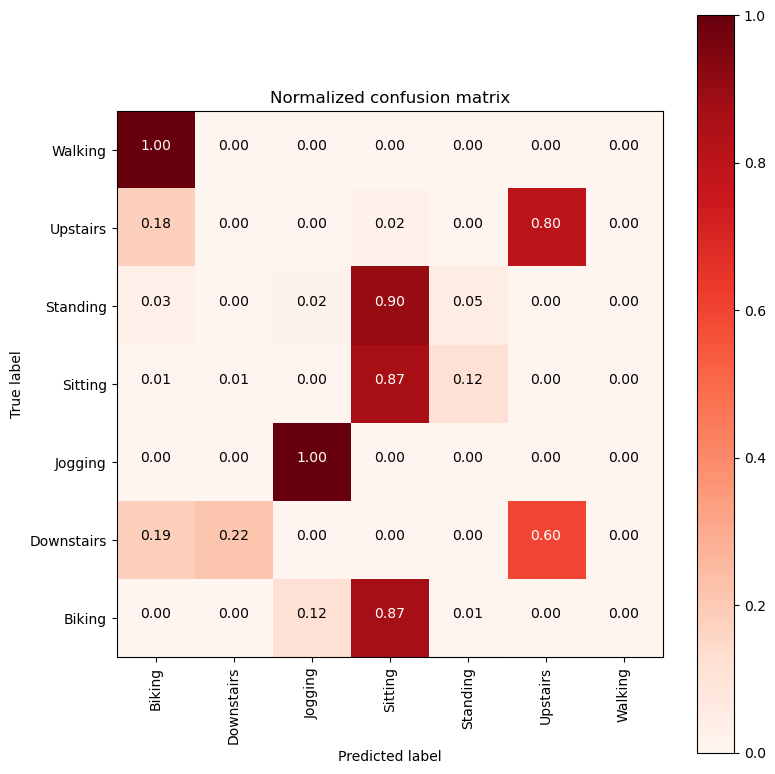

In [27]:
cm_wrist = confusion_matrix(y_wrist, prediction_wrist)

plt.rcParams['font.family'] = 'DejaVu Sans'

plt.figure(figsize=(8,8))
plt.grid(visible = False)
plot_confusion_matrix(cm_wrist, classes=labels1, normalize=True, title='Normalized confusion matrix', cmap = plt.cm.Reds)
ax = plt.gca()
ax.set_ylim(-.5,6.5)
plt.show()

In [28]:
print('----------------------------------------------')
print('| Classification Report for all Participants |')
print('----------------------------------------------')
cr_wrist = classification_report(y_wrist, prediction_wrist, target_names=labels1)
print(cr_wrist)

----------------------------------------------
| Classification Report for all Participants |
----------------------------------------------
              precision    recall  f1-score   support

      Biking       0.00      0.00      0.00       180
  Downstairs       0.95      0.22      0.35       189
     Jogging       0.88      1.00      0.94       180
     Sitting       0.33      0.87      0.47       180
    Standing       0.28      0.05      0.08       180
    Upstairs       0.56      0.80      0.66       180
     Walking       0.00      0.00      0.00       171

    accuracy                           0.42      1260
   macro avg       0.43      0.42      0.36      1260
weighted avg       0.44      0.42      0.36      1260



/home/paschalis/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/paschalis/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/paschalis/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
print('---------------------------------')
print('| Accuracy for all Participants |')
print('---------------------------------')
acc_score = accuracy_score(y_wrist, prediction_wrist)
print('\n\t{}\n'.format(acc_score))

---------------------------------
| Accuracy for all Participants |
---------------------------------

	0.42063492063492064

